## E8. 인물사진 만들기

이미지 세그멘테이션(Image segmentation)은 이미지에서 객체를 추출하는 기법이다. 이 중 시멘틱 세그멘테이션(semantic segmentation)은 이미지에서 픽셀을 사람, 고양이 등의 여러개의 클래스로 분류하는 classification 기법이다. 이 프로젝트의 목표는 다음과 같다.  
1. 인물사진에서 인물을 추출하고 배경을 흐리게 한다(blur 처리). 
2. 인물사진에서 인물을 추출할때 문제점을 지적하고 depth 의 정보를 활용 오류를 보완할 수 있는 솔루션을 제공한다. 
3. 고양이 사진에서 고양이를 추출하고 배경을 흐리게 한다. 
4. 고양이 사진에서 배경을 바꿔본다. 

### Executive Summary 
1. 내 사진을 가져다가 인물을 추출하고 배경을 blur 처리 했다. (사용한 모델: DeepLab v3)  
2. 내 인물 사진에서 두 팔이 추출이 되지 않았다. 이를 해결하기 위해서는 depth 의 정보를 활용할 수 있는 기술을 이용해야 하지만 이번 프로젝트 수행때는 문제점을 해결하지 못했다. 
3. 고양이 사진에서 고양이를 추출하고 배경을 blur 처리 했다. (사용한 모델: DeepLab v3) 
4. 고양이 사진에서 배경을 해변사진으로 대체해 봤다. 

### 필요한 모듈 가져오기

In [2]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

### 내 사진

In [20]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_pic2.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
my_img_orig = cv2.imread(img_path) 
print (my_img_orig.shape)

(2048, 1536, 3)


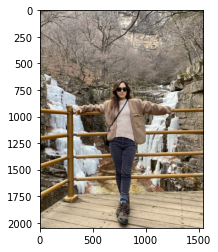

In [21]:
plt.imshow(cv2.cvtColor(my_img_orig, cv2.COLOR_BGR2RGB))

#### DeepLabModel 만들기 

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [5]:
# define model and download & load pretrained weight

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


#### Model에 내 사진 넣기 

In [28]:
my_img_resized, my_seg_map = MODEL.run(my_img_orig)
print (my_img_orig.shape, my_img_resized.shape, my_seg_map.max())

(2048, 1536, 3) (513, 384, 3) 17


In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

#### 내 사진에서 인물 추출하기 
* my_seg_map: 사람을 뜻하는 15을 사용하여 이미지에서 사람인 15는 15로 표현, 나머지는 0으로 표현하였다.      
* my_img_mask: 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 합니다. 
* applyColorMap(): 색을 적용하고 이미지를 화면에 출력합니다.

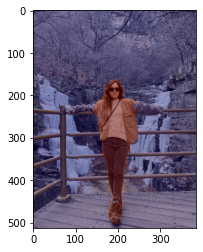

In [29]:
my_img_show = my_img_resized.copy()
my_seg_map = np.where(my_seg_map == 15, 15, 0) # 예측 중 사람만 추출
my_img_mask = my_seg_map * (255/my_seg_map.max()) # 255 normalization
my_img_mask = my_img_mask.astype(np.uint8)
my_color_mask = cv2.applyColorMap(my_img_mask, cv2.COLORMAP_JET)
my_img_show = cv2.addWeighted(my_img_show, 0.6, my_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(my_img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### 추출한 인물 이미지를 흑과 백으로 표현
왼쪽은 원본, 오른쪽은 DeepLab Model을 통해서 추출한 이미지

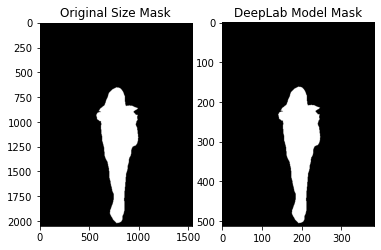

In [31]:
my_img_mask_up = cv2.resize(my_img_mask, my_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, my_img_mask_up = cv2.threshold(my_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(my_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(my_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#### Blur 필터를 적용

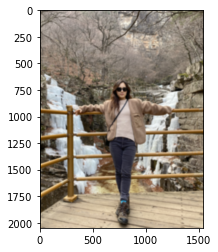

In [30]:
my_img_orig_blur = cv2.blur(my_img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(my_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 배경만 blur 처리 해주기 
my_img_bg_blur 만들어주기

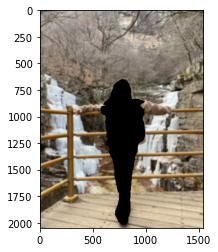

In [32]:
my_img_mask_color = cv2.cvtColor(my_img_mask_up, cv2.COLOR_GRAY2BGR)
my_img_bg_mask = cv2.bitwise_not(my_img_mask_color)
my_img_bg_blur = cv2.bitwise_and(my_img_orig_blur, my_img_bg_mask)
plt.imshow(cv2.cvtColor(my_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 원본 이미지에서는 인물을 제외하고 배경을 blur 처리 해줌

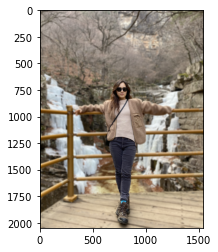

In [33]:
my_img_concat = np.where(my_img_mask_color==255, my_img_orig, my_img_bg_blur)
plt.imshow(cv2.cvtColor(my_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 고양이 사진 
고양이 사진을 이용해서 고양이를 추출하고 배경을 blur 처리 해줬다. 내 사진보다는 잘 됐다. 

In [36]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat_pic2.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
cat_img_orig = cv2.imread(img_path) 
print (cat_img_orig.shape)

(1536, 2048, 3)


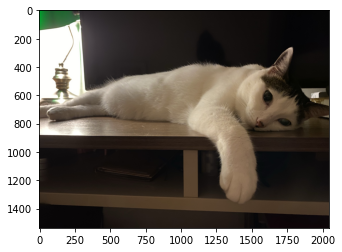

In [37]:
plt.imshow(cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB))

In [38]:
cat_img_resized, cat_seg_map = MODEL.run(cat_img_orig)
print (cat_img_orig.shape, cat_img_resized.shape, cat_seg_map.max())

(1536, 2048, 3) (384, 513, 3) 8


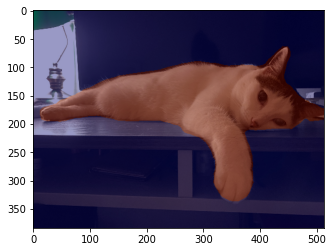

In [39]:
cat_img_show = cat_img_resized.copy()
cat_seg_map = np.where(cat_seg_map == 8, 8, 0) # 예측 중 고양이 추출
cat_img_mask = cat_seg_map * (255/cat_seg_map.max()) # 255 normalization
cat_img_mask = cat_img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

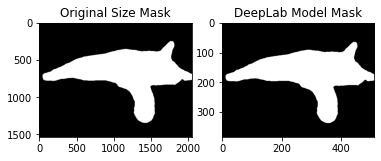

In [40]:
cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

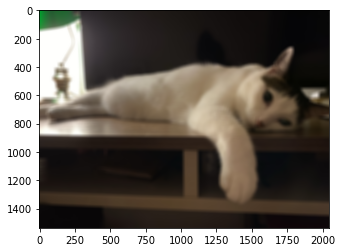

In [43]:
cat_img_orig_blur = cv2.blur(cat_img_orig, (30,30)) # blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(cat_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

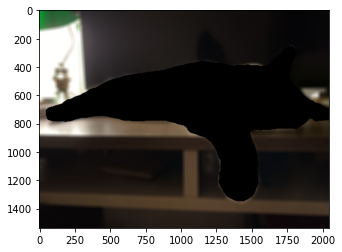

In [44]:
cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, cat_img_bg_mask)
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

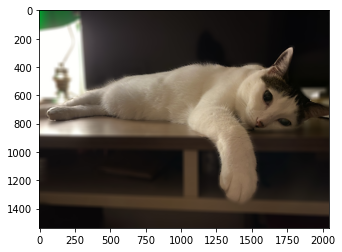

In [45]:
cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 고양이 사진 + 크로마키 배경 합성 

#### 배경사진 불러오고 resize 해주기 

In [46]:
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/beach_pic.jfif'  
bg_img_orig = cv2.imread(bg_img_path) 
print (bg_img_orig.shape)

(183, 275, 3)


In [48]:
print(cat_img_orig.shape)

(1536, 2048, 3)
(1536, 2048, 3)


In [52]:
# resize 
resized_bg_image = cv2.resize(bg_img_orig, (2048, 1536))

In [55]:
print(resized_bg_image.shape)

(1536, 2048, 3)


#### 배경합성 

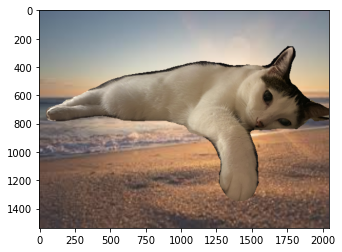

In [54]:
cat_img_concat_bg = np.where(cat_img_mask_color==255, cat_img_orig, resized_bg_image)
plt.imshow(cv2.cvtColor(cat_img_concat_bg, cv2.COLOR_BGR2RGB))
plt.show()